In [2]:
import pychastic
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd

y_drift = 4.0
sigma = 1
y_barrier = 2

problem = pychastic.sde_problem.SDEProblem(
    a=lambda x: jnp.array([1 / (2 * x[0]) + y_drift*jnp.sin(x[1]), y_drift*jnp.cos(x[1]) / x[0]]),
    b=lambda x: sigma*jnp.array(
        [[jnp.cos(x[1]), jnp.sin(x[1])], [-jnp.sin(x[1]) / x[0], jnp.cos(x[1]) / x[0]]]
    ),
    x0=jnp.array([2.0, 0.0]),
    tmax=1.0,
)

n_samples = 10000

solver = pychastic.sde_solver.SDESolver()
solver.scheme = 'euler'
solver.dt = 2**(-10)

100%|██████████| 32/32 [00:03<00:00,  8.39it/s]


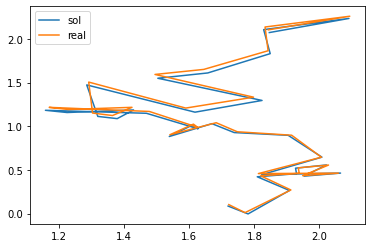

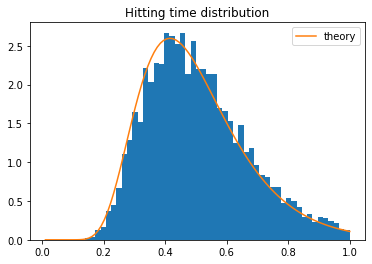

In [9]:
def process_trajectory(trajectory):
    hit_index = (trajectory[:, 1] > y_barrier).argmax()
    
    position_before = trajectory[hit_index-1]
    position_after = trajectory[hit_index]
    
    y_before = position_before[1]
    y_after = position_after[1]

    # linear interpolation
    weight = (y_barrier - y_before)/(y_after - y_before)    
    interpolated_hit_place = position_after*weight + position_before*(1-weight)
    interpolated_hit_index = hit_index+weight
    
    return {
        'interpolated_hit_place_x': interpolated_hit_place[0],
        'interpolated_hit_place_y': interpolated_hit_place[1],
        'interpolated_hit_index': interpolated_hit_index
    }

process_trajectory_vmapped = jax.vmap(process_trajectory)

def rmse(tensor):
    return jnp.sqrt((tensor**2).mean())

def analyze_solver(solver, plots=False):
    solution = solver.solve_many(problem,n_samples,seed=0)

    w1 = solution['wiener_values'][..., 0]
    w2 = solution['wiener_values'][..., 1]
    x_real = w1+2
    y_real = w2+y_drift*y_drift*solution['time_values'][0]/4  # /4?

    r_sol = solution['solution_values'][..., 0]
    phi_sol = solution['solution_values'][..., 1]
    x_sol = r_sol*jnp.cos(phi_sol)
    y_sol = r_sol*jnp.sin(phi_sol)

    hit_occured_in_solution = (y_sol > y_barrier).any(axis=1)
    hit_occured_in_real = (y_real > y_barrier).any(axis=1)
    hit_occured_in_both = hit_occured_in_solution & hit_occured_in_real

    trajectories_sol = jnp.stack([x_sol, y_sol], axis=-1)[hit_occured_in_both]  # (n_traj, step, coord)
    trajectories_real = jnp.stack([x_real, y_real], axis=-1)[hit_occured_in_both]

    processed_sol = process_trajectory_vmapped(trajectories_sol)
    processed_real = process_trajectory_vmapped(trajectories_real)

    hit_time_sol = processed_sol['interpolated_hit_index']*solver.dt
    hit_place_x_sol = processed_sol['interpolated_hit_place_x']
    hit_time_real = processed_real['interpolated_hit_index']*solver.dt
    hit_place_x_real = processed_real['interpolated_hit_place_x']

    hit_time_error = hit_time_sol - hit_time_real
    hit_place_x_error = hit_place_x_sol - hit_place_x_real

    hit_time_rmse = rmse(hit_time_error).item()
    hit_time_error_std = hit_time_error.std().item()
    hit_place_x_rmse = rmse(hit_place_x_error).item()
    hit_place_x_error_std = hit_place_x_error.std().item()

    if plots:
        n_traj = 0
        plt.plot(np.array(x_sol[n_traj]), np.array(y_sol[n_traj]), label='sol')
        plt.plot(np.array(x_real[n_traj]), np.array(y_real[n_traj]), label='real')
        plt.legend()
        plt.show()

        plt.figure()
        plt.hist(np.array(hit_time_sol), bins=min(50, n_samples//10), density=True)
        t = np.linspace(0, problem.tmax, 100)[1:]
        theoretical_hitting_time_desity = y_barrier/(sigma*np.sqrt(2*np.pi*t**3))*np.exp(-(y_barrier-y_drift*t)**2/(2*sigma**2*t))
        plt.plot(t, theoretical_hitting_time_desity, label='theory')
        plt.legend()
        plt.title('Hitting time distribution')
        plt.show()        

    return {
        'hit_time_sol': hit_time_sol,
        'hit_place_x_sol': hit_place_x_sol,
        'hit_time_real': hit_time_real,
        'hit_place_x_real': hit_place_x_real,

        'hit_time_rmse': hit_time_rmse,
        'hit_time_error_std': hit_time_error_std,
        'hit_place_x_rmse': hit_place_x_rmse,
        'hit_place_x_error_std': hit_place_x_error_std,
    }

result = analyze_solver(solver, plots=True);

In [23]:
schemes = ['euler', 'milstein', 'wagner_platen'][:2]
n_stepss = 2**np.arange(4, 16+1)[:6]
results = []

for scheme in schemes:
    for n_steps in n_stepss:
        print(scheme, n_steps)
        dt = problem.tmax / n_steps
        solver = pychastic.sde_solver.SDESolver(dt=dt, scheme=scheme)
        result = analyze_solver(solver)
        data = {k: v for k, v in result.items() if 'error' in k or 'rmse' in k}
        data['scheme'] = scheme
        data['n_steps'] = n_steps
        results.append(data)
        

  0%|          | 0/16 [00:00<?, ?it/s]

euler 16


  0%|          | 0/32 [00:00<?, ?it/s]

euler 32


  0%|          | 0/64 [00:00<?, ?it/s]

euler 64


  0%|          | 0/128 [00:00<?, ?it/s]

euler 128


  0%|          | 0/256 [00:00<?, ?it/s]

euler 256


  0%|          | 0/512 [00:00<?, ?it/s]

euler 512


  0%|          | 0/16 [00:00<?, ?it/s]

milstein 16


  0%|          | 0/32 [00:00<?, ?it/s]

milstein 32


  0%|          | 0/64 [00:00<?, ?it/s]

milstein 64


  0%|          | 0/128 [00:00<?, ?it/s]

milstein 128


  0%|          | 0/256 [00:00<?, ?it/s]

milstein 256


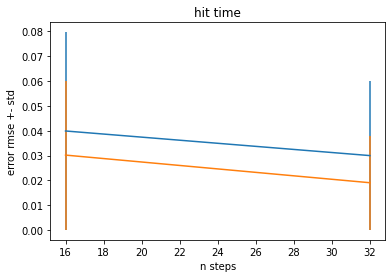

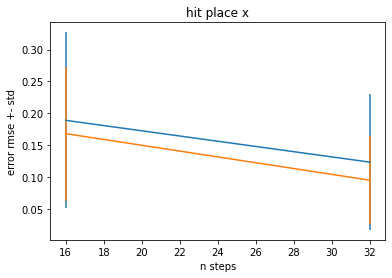

In [ ]:
plt.figure(dpi=150)
for scheme, df in pd.DataFrame(results).groupby('scheme'):
    plt.errorbar(df.n_steps, df.hit_time_rmse, yerr=df.hit_time_error_std, label='scheme')

plt.xlabel('n steps')
plt.ylabel('error rmse +- std')
plt.title('hit time')
plt.savefig('git_time.png')
plt.show()

plt.figure(dpi=150)
for scheme, df in pd.DataFrame(results).groupby('scheme'):
    plt.errorbar(df.n_steps, df.hit_place_x_rmse, yerr=df.hit_place_x_error_std, label='scheme')

plt.xlabel('n steps')
plt.ylabel('error rmse +- std')
plt.title('hit place x')
plt.savefig('hit_place.png')
plt.show()



